# Analysis of Variance

Perhaps there is no other statistical analysis as popular as the ANalysis Of VAriance. The main purpose of an ANOVA test is to detect whether the means of a specific observation variable between groups (e.g. grain yield of corn plots subjected to different levels of fertilizer application, biomass production of two watersheds exposed to different burning regimes, etc.) are *significantly* different. The word *significantly* has special meaning in this context and represents conclusion of our analysis under a set  error rate. As you can imagine, detecting whether two or more things are different from each other requires agreement on some baseline.

A one-way anova is used to test the hypothesis that the samples in the objective variable (e.g. biomass production) of different groups are drawn from populations with the same mean against the alternative hypothesis that the population means are not all the same. Rejecting the null hypothesis would imply that at least one of the means is different. 

In this exercise we will use a dataset of corn yield for different treatments of nitrogen fertilizer on multiple US states. The dataset is a subset of the study published by Tremblay et al., 2012 (see references for more details) and it was obtained from (http://www.nue.okstate.edu/).

Does the application of nitrogen fertilizer result in systematically greater corn yields or are the yield responses a mere consequence of random noise due to sampling?


In [201]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison


In [216]:
# Load data
df = pd.read_csv("../datasets/corn_nue_multiple_locs.csv")
df.head()


,Year,State,Site,Textural_class,Replications,Treatments,N_Planting_kg_ha,N_Sidedress_kg_ha,N_Total_kg_ha,Yield_T_ha
0,2006,Illinois,Pad,Silt loam,1,1,0,0,0,3.26
1,2006,Illinois,Pad,Silt loam,1,3,36,0,36,4.15
2,2006,Illinois,Pad,Silt loam,1,5,36,54,90,8.64
3,2006,Illinois,Pad,Silt loam,1,7,36,107,143,10.52
4,2006,Illinois,Pad,Silt loam,1,9,36,161,197,11.47


In [217]:
# Print some useful properties of the dataset
print(df['Site'].unique())        # Locations
print(df['Treatments'].unique())   # Treatments
print(df['Replications'].unique()) # Replications
print(df.shape)


['Pad' 'Dixon' 'Manhattan' 'Copeland' 'Diederick']
[1 3 5 7 9]
[1 2 3 4]
(120, 10)


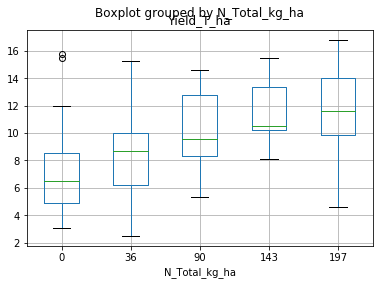

In [269]:
# Examine yield data using boxplots for all locations combined
df.boxplot(column='Yield_T_ha', by='N_Total_kg_ha')
plt.show()


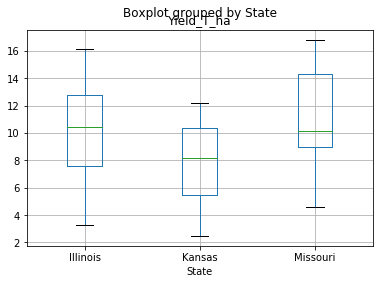

In [273]:
# Examine yield by state
df.boxplot(column='Yield_T_ha', by='State')
plt.show()


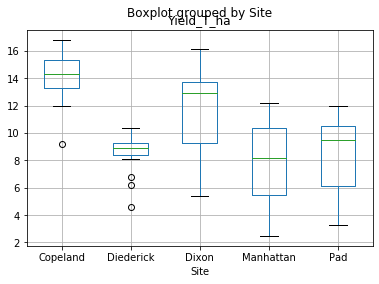

In [274]:
# Examine yield by site
df.boxplot(column='Yield_T_ha', by='Site')
plt.show()


## ANOVA assumptions

1. Samples drawn from a population are normally distributed. **Test**: Shapiro-Wilk

2. Samples drawn from all populations have (approximately) the same variance. This property is called homoscedasticity or homogeneity of variances." **Tests**: Bartlett's and Levene's tests.

3. Samples are independent of each other. Test: No test. Here we rely on the nature of the variable being observed and the experimental design.


## One-way ANOVA

Here we will compare an independent variable with a single predictor. The predictor `N_Total_kg_ha` will be used as a categorical varaible. Alternatively we could use the `Treatments` column, but it is easier to read the table if we present the values using the actual treatment values, so that we quickly devise which Nitrogen rates show statistical differences.


In [236]:
# Anova table with statsmodels
formula = 'Yield_T_ha ~ C(N_Total_kg_ha)'
lm = ols(formula, data=df).fit()
anova_statsmodels = anova_lm(lm)
anova_statsmodels


,df,sum_sq,mean_sq,F,PR(>F)
C(N_Total_kg_ha),4.0,386.085542,96.521385,11.431259,7.582811e-08
Residual,115.0,971.018108,8.443636,NaN,NaN


The ANOVA table shows the there is significant differences between treatments. The catch is that we don't know which groups are different. The ANOVA table only tells us that at least one  group has a mean value that is substantially (read *significantly*) different from the rest.

The **F** is the F-statistic to test the null hypothesis that the corresponding coefficient is zero.

The **pValue** of the F-statistic indicates whether a factor is not significant at the 5% significance level given the other terms in the model.

A mean multicomparison test can help us identify which treatments show signifcant differences.


In [237]:
# Multicomparison test
groups = MultiComparison(df["Yield_T_ha"],df['N_Total_kg_ha']).tukeyhsd(alpha=0.05)
print(groups)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0     36   1.3175 0.5165 -1.0074 3.6424  False
     0     90   3.0358  0.004  0.7109 5.3607   True
     0    143   4.3096  0.001  1.9847 6.6345   True
     0    197   4.7454  0.001  2.4205 7.0703   True
    36     90   1.7183 0.2499 -0.6066 4.0432  False
    36    143   2.9921 0.0047  0.6672  5.317   True
    36    197   3.4279  0.001   1.103 5.7528   True
    90    143   1.2738 0.5458 -1.0512 3.5987  False
    90    197   1.7096 0.2547 -0.6153 4.0345  False
   143    197   0.4358    0.9 -1.8891 2.7607  False
---------------------------------------------------


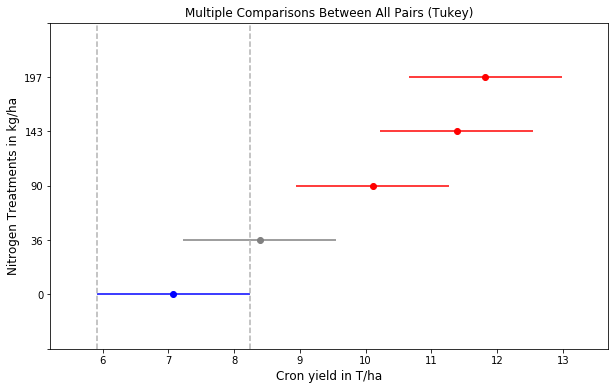

In [243]:
# Visualize significantly different groups relative to a specific group
groups.plot_simultaneous(comparison_name=0)
plt.xlabel('Cron yield in T/ha', size=12)
plt.ylabel('Nitrogen Treatments in kg/ha', size=12)
plt.show()


## Two-way ANOVA

In this case we will add two predictors variables, soil textural class and total nitrogen applied. In many cases researchers add `Location` as a proxy for local environmental conditions (including soil) and `Year` as a proxy for the particular weather conditions during each growing season. In this case we have soil textural class available, so we will make use of that first, since it will give our results broader applications that, in principle, can be related to soil types elsewhere.


In [240]:
# Two predictors
formula = 'Yield_T_ha ~ C(N_Total_kg_ha) + C(Textural_class)'
anova_lm(ols(formula, data=df).fit())


,df,sum_sq,mean_sq,F,PR(>F)
C(N_Total_kg_ha),4.0,386.085542,96.521385,11.750059,5.022955e-08
C(Textural_class),1.0,34.560000,34.560000,4.207172,4.254546e-02
Residual,114.0,936.458108,8.214545,NaN,NaN


Soil textual class was barely significant considering all locations and years at the the 0.05 level.

In [241]:
# Two predictors with interaction
formula = 'Yield_T_ha ~ C(N_Total_kg_ha) * C(Textural_class)'
anova_lm(ols(formula, data=df).fit())


,df,sum_sq,mean_sq,F,PR(>F)
C(N_Total_kg_ha),4.0,386.085542,96.521385,12.530231,1.960683e-08
C(Textural_class),1.0,34.560000,34.560000,4.486516,3.641510e-02
C(N_Total_kg_ha):C(Textural_class),4.0,89.119178,22.279795,2.892322,2.547188e-02
Residual,110.0,847.338930,7.703081,NaN,NaN


The interaction of nitrogen rate and textural class also resulted statistically significant at the 0.05 level.

In [261]:
# Classical ANOVA with Treatment, Location, and Year interactions
formula = 'Yield_T_ha ~ C(N_Total_kg_ha) * State * C(Year)'
anova_lm(ols(formula, data=df).fit())


,df,sum_sq,mean_sq,F,PR(>F)
C(N_Total_kg_ha),4.0,386.085542,96.521385,20.522835,3.270251e-12
State,2.0,234.432785,117.216393,24.923106,1.989675e-09
C(Year),2.0,112.504702,56.252351,11.960642,2.328310e-05
C(N_Total_kg_ha):State,8.0,140.688973,17.586122,3.739245,7.649526e-04
C(N_Total_kg_ha):C(Year),8.0,36.595110,4.574389,0.972628,4.621589e-01
State:C(Year),4.0,3.702425,0.925606,0.196807,9.394924e-01
C(N_Total_kg_ha):State:C(Year),16.0,17.058994,1.066187,0.226698,9.991834e-01
Residual,95.0,446.796537,4.703121,NaN,NaN


In a multi-treatment, multi-year, and multi-state study, it is not surprising that treatment, site, and year resulted highly significant (P<0.01).

Note that the interactions `N_Total_kg_ha:Year`, `State:Year`, and `N_Total_kg_ha:State:Year` were not significant at the P<0.05 level.

## References

Tremblay, N.,  Y.M. Bouroubi,  C. Bélec,  R.W. Mullen,  N.R. Kitchen,  W.E. Thomason,  S. Ebelhar,  D.B. Mengel,  W.R. Raun,  D.D. Francis,  E.D. Vories, and I. Ortiz-Monasterio. 2012. Corn response to nitrogen is influenced by soil texture and weather. Agron. J. 104:1658–1671. doi:10.2134/agronj2012.018.
